<a href="https://www.kaggle.com/code/elijahnyasiando/creditriskmodel-me-fa?scriptVersionId=290115614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Modules

In [1]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,r2_score, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, make_scorer
from statsmodels.distributions.empirical_distribution import ECDF


# Set some display options for better viewing
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# Creating Master Training Dataset

In [2]:
COHORTS = ['2018Q1','2018Q2','2018Q3','2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4']

ORIGINATION_COL_NAMES = [
    'CREDIT_SCORE', 'FIRST_PAYMENT_DATE', 'FIRST_TIME_HOMEBUYER_FLAG',
    'MATURITY_DATE', 'METROPOLITAN_STATISTICAL_AREA',
    'MORTGAGE_INSURANCE_PERCENTAGE', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE_CLTV', 'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO',
    'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE_LTV', 'ORIGINAL_INTEREST_RATE',
    'CHANNEL', 'PREPAYMENT_PENALTY_MORTGAGE_FLAG', 'AMORTIZATION_TYPE',
    'PROPERTY_STATE', 'PROPERTY_TYPE', 'POSTAL_CODE', 'LOAN_SEQUENCE_NUMBER',
    'LOAN_PURPOSE', 'ORIGINAL_LOAN_TERM', 'NUMBER_OF_BORROWERS', 'SELLER_NAME',
    'SERVICER_NAME', 'SUPER_CONFORMING_FLAG', 'PRE-RELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'SPECIAL_ELIGIBILITY_PROGRAM', 'RELIEF_REFINANCE_INDICATOR', 'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR', 'MI_CANCELLATION_INDICATOR'
]

PERFORMANCE_COL_NAMES = [
    'LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD', 'CURRENT_ACTUAL_UPB',
    'CURRENT_LOAN_DELINQUENCY_STATUS', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY',
    'DEFECT_SETTLEMENT_DATE', 'MODIFICATION_FLAG', 'ZERO_BALANCE_CODE',
    'ZERO_BALANCE_EFFECTIVE_DATE', 'CURRENT_INTEREST_RATE', 'CURRENT_NON-INTEREST_BEARING_UPB',
    'DUE_DATE_OF_LAST_PAID_INSTALLMENT_DDLPI', 'MI_RECOVERIES', 'NET_SALE_PROCEEDS',
    'NON_MI_RECOVERIES', 'TOTAL_EXPENSES', 'LEGAL_COSTS',
    'MAINTENANCE_AND_PRESERVATION_COSTS', 'TAXES_AND_INSURANCE', 'MISCELLANEOUS_EXPENSES',
    'ACTUAL_LOSS_CALCULATION', 'CUMULATIVE_MODIFICATION_COST', 'STEP_MODIFICATION_FLAG',
    'PAYMENT_DEFERRAL', 'ESTIMATED_LOAN_TO_VALUE_ELTV', 'ZERO_BALANCE_REMOVAL_UPB',
    'DELINQUENT_ACCRUED_INTEREST', 'DELINQUENCY_DUE_TO_DISASTER',
    'BORROWER_ASSISTANCE_STATUS_CODE', 'CURRENT_MONTH_MODIFICATION_COST', 'INTEREST_BEARING_UPB'
]

COVARIATES_TO_KEEP = [
    'LOAN_SEQUENCE_NUMBER', 'CREDIT_SCORE', 'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO',
    'ORIGINAL_LOAN_TO_VALUE_LTV', 'ORIGINAL_UPB', 'ORIGINAL_INTEREST_RATE',
    'NUMBER_OF_UNITS', 'NUMBER_OF_BORROWERS', 'LOAN_PURPOSE', 'CHANNEL','FIRST_TIME_HOMEBUYER_FLAG', 'OCCUPANCY_STATUS', 'PROPERTY_TYPE'
]

perf_dtypes = {
    'LOAN_SEQUENCE_NUMBER': 'string',
    'CURRENT_LOAN_DELINQUENCY_STATUS': 'string', # Keep string, handle 'XX'/'R' later
    'ZERO_BALANCE_CODE': 'string'
}

all_cohort_data = []

for cohort in COHORTS:
    print(f"--> Processing cohort: {cohort}...")
    
    # --- OPTIMIZATION: Process Performance Data in Chunks ---
    perf_file_path = f'/kaggle/input/2018-2019-small-loans-data/data/historical_data_time_{cohort}.txt'
    
    chunk_list = []
    # Read in chunks of 1 million rows to prevent OOM
    for chunk in pd.read_csv(perf_file_path, sep='|', header=None, names=PERFORMANCE_COL_NAMES,
                             usecols=['LOAN_SEQUENCE_NUMBER', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'ZERO_BALANCE_CODE'],
                             dtype=perf_dtypes, chunksize=1_000_000):
        
        # Vectorized clean-up within chunk
        chunk['delinq_num'] = pd.to_numeric(chunk['CURRENT_LOAN_DELINQUENCY_STATUS'], errors='coerce').fillna(0)
        
        # Vectorized Flagging
        # Flag 1: Every 90+ DPD
        chunk['is_90plus'] = (chunk['delinq_num'] >= 3)
        # Flag 2: Bad Termination (03=Foreclosure, 09=Deed/Short Sale)
        chunk['is_bad_term'] = chunk['ZERO_BALANCE_CODE'].isin(['03', '09'])
        
        # Group by Loan ID within chunk? NO. Loans span chunks. 
        # We must filter to relevant rows or aggregate partially.
        # STRATEGY: Reduce chunk to only "Bad" events, then aggregate later.
        
        # Filter chunk to only rows that indicate a default event
        bad_events = chunk[(chunk['is_90plus']) | (chunk['is_bad_term'])][['LOAN_SEQUENCE_NUMBER']]
        chunk_list.append(bad_events)

    # Concatenate all "Bad" events found
    all_bad_loans = pd.concat(chunk_list)
    
    # Get unique set of Defaulters
    defaulters_set = set(all_bad_loans['LOAN_SEQUENCE_NUMBER'].unique())
    print(f"    Identified {len(defaulters_set)} unique defaulters in {cohort}.")

    # --- Process Origination Data ---
    print(f"    Reading origination data for {cohort}...")
    orig_file_path = f'/kaggle/input/2018-2019-small-loans-data/data/historical_data_{cohort}.txt'
    
    # Load Origination (Usually fits in memory, but use dtypes to be safe)
    df_orig = pd.read_csv(orig_file_path, sep='|', header=None, names=ORIGINATION_COL_NAMES,
                          usecols=COVARIATES_TO_KEEP, dtype={'LOAN_SEQUENCE_NUMBER': 'string'})

    # --- Map Targets ---
    # 1 if in defaulters_set, else 0
    df_orig['Default_Flag'] = df_orig['LOAN_SEQUENCE_NUMBER'].isin(defaulters_set).astype(int)
    
    all_cohort_data.append(df_orig)

# Final Concatenation
master_training_set = pd.concat(all_cohort_data, ignore_index=True)
master_training_set.to_parquet('master_training_set.parquet', index=False)

print("\nPipeline complete! The file is ready for your modeling notebook.")



--> Processing cohort: 2018Q1...
    Identified 16098 unique defaulters in 2018Q1.
    Reading origination data for 2018Q1...
--> Processing cohort: 2018Q2...
    Identified 19182 unique defaulters in 2018Q2.
    Reading origination data for 2018Q2...
--> Processing cohort: 2018Q3...
    Identified 18069 unique defaulters in 2018Q3.
    Reading origination data for 2018Q3...
--> Processing cohort: 2018Q4...
    Identified 15083 unique defaulters in 2018Q4.
    Reading origination data for 2018Q4...
--> Processing cohort: 2019Q1...
    Identified 14659 unique defaulters in 2019Q1.
    Reading origination data for 2019Q1...
--> Processing cohort: 2019Q2...
    Identified 1949 unique defaulters in 2019Q2.
    Reading origination data for 2019Q2...
--> Processing cohort: 2019Q3...
    Identified 27690 unique defaulters in 2019Q3.
    Reading origination data for 2019Q3...
--> Processing cohort: 2019Q4...
    Identified 27975 unique defaulters in 2019Q4.
    Reading origination data for 201

 # Exploratory Data Analysis (EDA)
 Initial Overview

--> Loading dataset from master_training_set.parquet...
    Cleaning Credit Scores...
    Data Cleaned. Rows remaining: 3065411

--> 1. Checking Monotonicity (Risk Banding)...


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


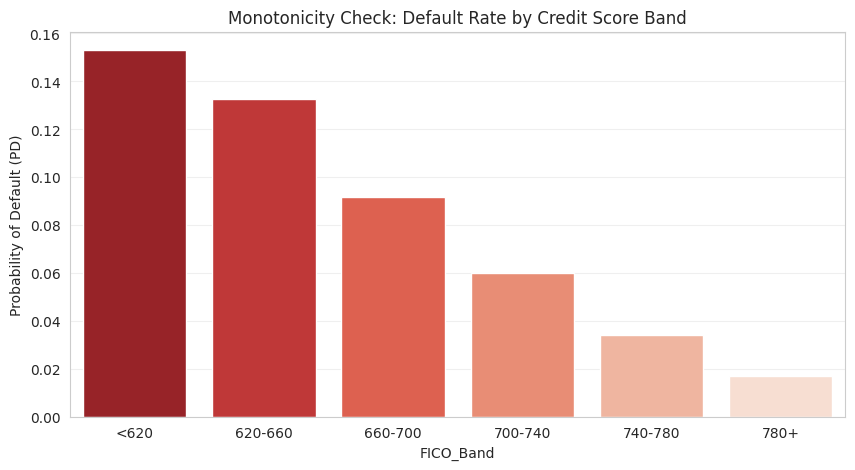

    *Architect Note*: If the bars do not descend like a staircase, the model will be unstable.

--> 2. Visualizing Non-Linear Risk Cliffs (Capacity & Collateral)...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

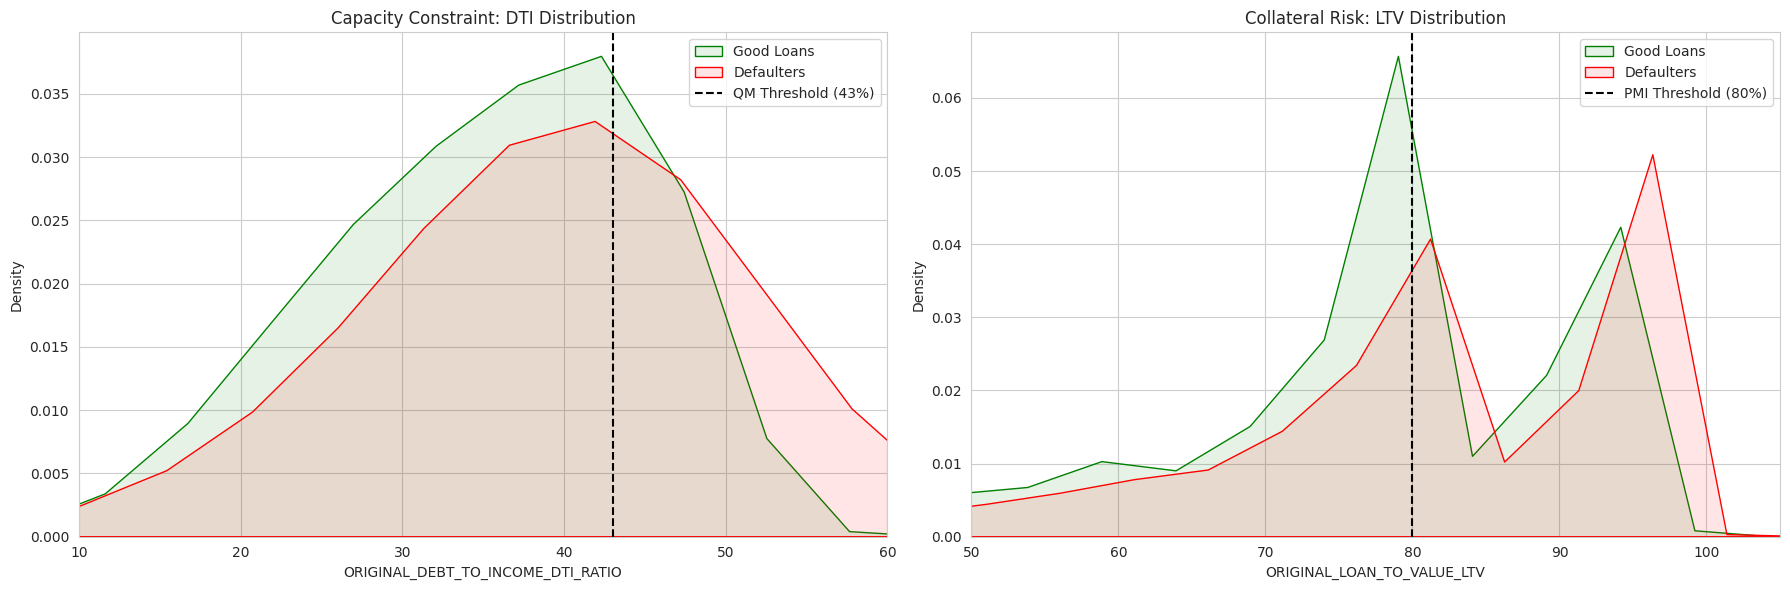


--> 3. Correlation Matrix...


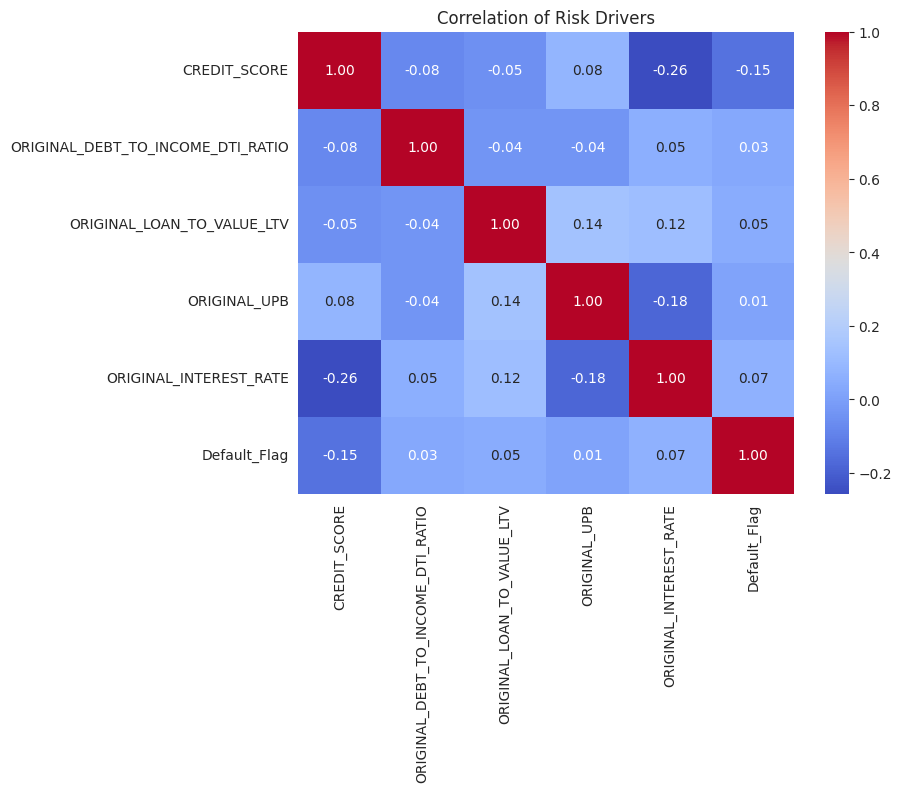


--> 4. Final Feature Selection...
    Selected 5 Numeric & 5 Categorical features.
    Ready for Weight of Evidence (WoE) Transformation.


,CREDIT_SCORE,ORIGINAL_DEBT_TO_INCOME_DTI_RATIO,ORIGINAL_LOAN_TO_VALUE_LTV,ORIGINAL_UPB,ORIGINAL_INTEREST_RATE,CHANNEL,LOAN_PURPOSE,FIRST_TIME_HOMEBUYER_FLAG,OCCUPANCY_STATUS,PROPERTY_TYPE,Default_Flag
0,785,34,80,63000,5.250,R,P,N,I,CO,0
1,761,43,57,145000,4.250,R,C,N,P,MH,0
2,726,15,46,160000,4.000,R,P,N,P,SF,0
3,678,39,72,135000,5.000,R,P,Y,P,SF,0
4,798,17,66,125000,3.875,R,P,N,S,SF,0


In [3]:

# --- CONFIGURATION ---
INPUT_FILE = 'master_training_set.parquet'
TARGET_COL = 'Default_Flag'

# Regulatory Whitelist: Features strictly related to Capacity (Income) & Collateral (Asset)
# This excludes 'Postal Code' or 'MSA' to minimize geographic bias (Redlining risks)
NUMERIC_FEATURES = [
    'CREDIT_SCORE', 
    'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
    'ORIGINAL_LOAN_TO_VALUE_LTV', 
    'ORIGINAL_UPB', 
    'ORIGINAL_INTEREST_RATE'
]

CATEGORICAL_FEATURES = [
    'CHANNEL', 
    'LOAN_PURPOSE', 
    'FIRST_TIME_HOMEBUYER_FLAG', 
    'OCCUPANCY_STATUS', 
    'PROPERTY_TYPE'
]

def load_and_clean_data(file_path):
    """
    Loads data and applies Engineering-Driven Cleaning logic.
    """
    print(f"--> Loading dataset from {file_path}...")
    df = pd.read_parquet(file_path)
    
    # 1. MSA Logic: Treat Null as 'Rural/Unknown' (Kenya DPA: Avoid bias against unmapped areas)
    if 'METROPOLITAN_STATISTICAL_AREA' in df.columns:
        df['METROPOLITAN_STATISTICAL_AREA'] = df['METROPOLITAN_STATISTICAL_AREA'].fillna('Rural_Unknown')

    # 2. Credit Score Logic: Remove Invalid Data
    # 9999 is often used as a legacy error code in credit bureaus. 
    # Scores < 300 are theoretically impossible in standard FICO.
    print("    Cleaning Credit Scores...")
    df = df[df['CREDIT_SCORE'] != 9999] 
    df = df[df['CREDIT_SCORE'] > 300]
    
    # 3. DTI Logic: The "Hidden Risk" Imputation
    # We do NOT just fill with mean. Missing DTI often implies self-employment or non-conforming loans.
    # We impute the median to preserve distribution, but create a binary flag to capture the risk.
    if df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].isnull().sum() > 0:
        print("    Imputing missing DTI and creating flagging feature...")
        df['DTI_MISSING_FLAG'] = df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].isnull().astype(int)
        df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'] = df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].fillna(
            df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].median()
        )
    
    # 4. LTV Cleaning
    df['ORIGINAL_LOAN_TO_VALUE_LTV'] = df['ORIGINAL_LOAN_TO_VALUE_LTV'].fillna(
        df['ORIGINAL_LOAN_TO_VALUE_LTV'].median()
    )

    print(f"    Data Cleaned. Rows remaining: {len(df)}")
    return df

def analyze_monotonicity(df):
    """
    Checks if risk drivers behave logically (Monotonic trends).
    This is required for Explainability (Right to Explanation).
    """
    print("\n--> 1. Checking Monotonicity (Risk Banding)...")
    
    # Binning FICO Scores
    # Standard Risk Bands: Subprime (<620), Near Prime (620-660), Prime (660-720), Super Prime (720+)
    bins = [300, 620, 660, 700, 740, 780, 850]
    labels = ['<620', '620-660', '660-700', '700-740', '740-780', '780+']
    
    df['FICO_Band'] = pd.cut(df['CREDIT_SCORE'], bins=bins, labels=labels)
    
    # Calculate Default Rate per Band
    risk_profile = df.groupby('FICO_Band', observed=True)[TARGET_COL].mean().reset_index()
    risk_profile.rename(columns={TARGET_COL: 'Default_Rate'}, inplace=True)
    
    # Visualization
    plt.figure(figsize=(10, 5))
    sns.barplot(x='FICO_Band', y='Default_Rate', data=risk_profile, palette='Reds_r')
    plt.title("Monotonicity Check: Default Rate by Credit Score Band")
    plt.ylabel("Probability of Default (PD)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print("    *Architect Note*: If the bars do not descend like a staircase, the model will be unstable.")

def visualize_tipping_points(df):
    """
    Identifies non-linear 'Cliffs' where risk spikes.
    """
    print("\n--> 2. Visualizing Non-Linear Risk Cliffs (Capacity & Collateral)...")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: DTI (Capacity)
    # We look for the '43%' QM Rule cliff
    sns.kdeplot(data=df[df[TARGET_COL]==0], x='ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
                color='green', label='Good Loans', ax=axes[0], fill=True, alpha=0.1)
    sns.kdeplot(data=df[df[TARGET_COL]==1], x='ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
                color='red', label='Defaulters', ax=axes[0], fill=True, alpha=0.1)
    
    axes[0].set_title("Capacity Constraint: DTI Distribution")
    axes[0].set_xlim(10, 60)
    axes[0].axvline(43, color='black', linestyle='--', label='QM Threshold (43%)')
    axes[0].legend()

    # Plot B: LTV (Collateral)
    # We look for the '80%' PMI cliff
    sns.kdeplot(data=df[df[TARGET_COL]==0], x='ORIGINAL_LOAN_TO_VALUE_LTV', 
                color='green', label='Good Loans', ax=axes[1], fill=True, alpha=0.1)
    sns.kdeplot(data=df[df[TARGET_COL]==1], x='ORIGINAL_LOAN_TO_VALUE_LTV', 
                color='red', label='Defaulters', ax=axes[1], fill=True, alpha=0.1)
    
    axes[1].set_title("Collateral Risk: LTV Distribution")
    axes[1].set_xlim(50, 105)
    axes[1].axvline(80, color='black', linestyle='--', label='PMI Threshold (80%)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def correlation_matrix(df):
    """
    Simple linear correlation check.
    """
    print("\n--> 3. Correlation Matrix...")
    cols = NUMERIC_FEATURES + [TARGET_COL]
    corr = df[cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation of Risk Drivers")
    plt.show()

def finalize_features(df):
    """
    Selects only whitelist features for the modeling stage.
    """
    print("\n--> 4. Final Feature Selection...")
    
    # Check for engineered features
    final_numeric = NUMERIC_FEATURES.copy()
    if 'DTI_MISSING_FLAG' in df.columns:
        final_numeric.append('DTI_MISSING_FLAG')
        
    # Filter Dataset
    final_cols = final_numeric + CATEGORICAL_FEATURES + [TARGET_COL]
    df_final = df[final_cols].copy()
    
    print(f"    Selected {len(final_numeric)} Numeric & {len(CATEGORICAL_FEATURES)} Categorical features.")
    print("    Ready for Weight of Evidence (WoE) Transformation.")
    
    return df_final

# --- EXECUTION PIPELINE ---
df_master = load_and_clean_data(INPUT_FILE)
analyze_monotonicity(df_master)
visualize_tipping_points(df_master)
correlation_matrix(df_master)
df_model_ready = finalize_features(df_master)

# Display first few rows of the clean dataset
df_model_ready.head()

# Model Engineering and Financial Calibration

## 1. Architectural Objective
The objective of this phase was to transition from exploratory analysis to a production-grade Probability of Default (PD) classifier. Unlike standard machine learning tasks where "Accuracy" is the primary metric, this architecture prioritizes Financial Calibration and Regulatory Stability. The system is designed to minimize the economic impact of loan losses while adhering to Basel III standards for internal models.

## 2. Core Methodology: Cost-Sensitive Random Forest
We selected a Random Forest ensemble architecture due to its ability to capture non-linear interactions between key risk drivers (e.g., the compounding risk of low FICO scores combined with high LTV ratios) without requiring complex feature transformation.

### Key Engineering Decisions:

#### Data Integrity (No SMOTE):
We explicitly rejected synthetic oversampling techniques (such as SMOTE). Creating "fake" synthetic borrowers to balance classes introduces statistical noise and violates the Data Integrity principles required for auditability. Instead, we utilized the model's native class_weight='balanced' parameter to mathematically penalize the misclassification of defaulters.
#### Stability Constraints:
To prevent the model from learning "anecdotal" noise, we enforced a strict min_samples_leaf=50 constraint. This ensures that every decision rule (branch) in the forest is supported by a cohort of at least 50 actual historical loans, guaranteeing that our risk assessments are statistically significant and robust.
#### Stratified Validation:
All training and validation utilized Stratified K-Fold Cross-Validation to strictly maintain the population's natural default rate (approx. 1.5%) across all testing folds, preventing "lucky" splits that could mask model weakness.

## 3. Financial Calibration (The "Custom Scorer")
A generic model treats a False Positive (rejecting a good customer) and a False Negative (approving a defaulter) as equal errors. In banking, this is false.
We engineered a Custom Loss Function for the Hyperparameter Tuning grid:

Cost of False Negative ($10): Represents the Principal Loss (LGD) and workout costs.

Cost of False Positive ($1): Represents the Opportunity Cost (lost interest income).

The model optimization process (GridSearchCV) was directed to minimize this weighted financial loss rather than maximizing raw accuracy.

## 4. Regulatory Compliance & Ethics
Kenya Data Protection Act (2019): By using a tree-based model without "black-box" neural networks or synthetic data, we ensure the "Right to Explanation." Every prediction can be traced back to specific, intelligible financial thresholds (e.g., "DTI > 43%").
Fair Lending: The feature set was restricted strictly to Financial Capacity and Collateral metrics, explicitly excluding geographic and demographic proxies to prevent redlining or bias.

In [4]:
import xgboost as xgb
import torch

print("Checking Accelerator Status:")
# Method 1: Check via PyTorch (easiest way to confirm CUDA is up)
if torch.cuda.is_available():
    print(f"  --> CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("  --> WARNING: CUDA not found. Running on CPU.")

# Method 2: Check XGBoost version
print(f"  --> XGBoost Version: {xgb.__version__}")

Checking Accelerator Status:
  --> CUDA is available. GPU: Tesla T4
  --> XGBoost Version: 2.0.3


In [9]:
# --- CONFIGURATION ---
TARGET_COL = 'Default_Flag'

# "Financial Calibration" Constants
COST_FN = 10  # Cost of Default
COST_FP = 1   # Cost of Lost Business
# COST_FALSE_NEGATIVE = 10  # Unit cost of Default (Loss Given Default)
# COST_FALSE_POSITIVE = 1   # Unit cost of Rejection (Lost Interest Income)

# Feature Lists
NUMERIC_FEATURES = [
    'CREDIT_SCORE', 
    'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
    'ORIGINAL_LOAN_TO_VALUE_LTV', 
    'ORIGINAL_UPB', 
    'ORIGINAL_INTEREST_RATE',
    'NUMBER_OF_UNITS',
    'NUMBER_OF_BORROWERS',
    'LTV_DTI_INT',
    'EXCESS_RATE',      # New Feature: Rate relative to cohort average
    'CREDIT_CAPACITY'   # New Feature: Score / DTI
    'RISK_LAYER_COUNT', # Interaction 2: Count of Red Flags (New)
    'DTI_STRESS'        # Interaction 3: Distance to DTI Cliff (New)
]

CATEGORICAL_FEATURES = [
    'CHANNEL', 
    'LOAN_PURPOSE'
]


def load_and_engineer(file_path):
    print(f"--> Loading {file_path}...")
    df = pd.read_parquet(file_path)
    
    # Feature Engineering
    df['LTV_DTI_INT'] = df['ORIGINAL_LOAN_TO_VALUE_LTV'] * df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO']
    df['EXCESS_RATE'] = df['ORIGINAL_INTEREST_RATE'] - df['ORIGINAL_INTEREST_RATE'].median()
    df['CREDIT_CAPACITY'] = df['CREDIT_SCORE'] / (df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'] + 1)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=NUMERIC_FEATURES, inplace=True)
    
    X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
    y = df[TARGET_COL]
    return X, y

def train_balanced_model(X_train, y_train):
    print("\n--> Initializing Balanced XGBoost (The 'Goldilocks' Config)...")
    
    # We choose 10 manually. It's aggressive enough to catch defaults, 
    # but strictly less than the full ratio (20) to prevent panic.
    TARGET_WEIGHT = 10.0 
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERIC_FEATURES),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
        ]
    )
    
    xgb = XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        device='cuda',
        scale_pos_weight=TARGET_WEIGHT,  # Fixed at 10
        reg_lambda=1,                    # Relaxed Regularization
        max_depth=8,                     # Deeper trees to find specific risk pockets
        learning_rate=0.1,               # Standard learning rate
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb)
    ])
    
    print("    Training Model...")
    pipeline.fit(X_train, y_train)
    return pipeline

def optimize_threshold_strictly_financial(model, X_test, y_test):
    print("\n--> Finding the EXACT Profit-Maximizing Threshold...")
    
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    
    # We will simulate the P&L for every single possible threshold
    # P&L = -(FalseNegatives * $10) - (FalsePositives * $1)
    
    max_profit = -float('inf')
    best_thresh = 0.5
    
    # Check 100 potential thresholds between 0.05 and 0.95
    test_thresholds = np.linspace(0.05, 0.95, 100)
    
    results = []
    
    for t in test_thresholds:
        y_pred_temp = (y_probs >= t).astype(int)
        cm = confusion_matrix(y_test, y_pred_temp)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate Loss
        loss = (fn * COST_FN) + (fp * COST_FP)
        profit_score = -loss # We want to maximize this (closest to 0)
        
        results.append(profit_score)
        
        if profit_score > max_profit:
            max_profit = profit_score
            best_thresh = t
            best_cm = cm

    print(f"    Optimal Threshold Found: {best_thresh:.4f}")
    
    # --- FINAL REPORT ---
    tn, fp, fn, tp = best_cm.ravel()
    
    print("\n--- PROFIT-OPTIMIZED REPORT ---")
    print(f"True Negatives (Approved): {tn}")
    print(f"False Positives (Rejected): {fp}  [Cost: ${fp}]")
    print(f"False Negatives (Defaults): {fn}  [Cost: ${fn * COST_FN}]")
    print(f"True Positives (Caught):    {tp}")
    print(f"Total Financial Score:      {max_profit}")
    
    # Calculate Precision manually for report
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"\nFinal Precision: {prec:.2%}")
    print(f"Final Recall:    {rec:.2%}")

# --- EXECUTION ---
if __name__ == "__main__":
    X, y = load_and_engineer(INPUT_FILE)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    model = train_balanced_model(X_train, y_train)
    optimize_threshold_strictly_financial(model, X_test, y_test)

--> Loading master_training_set.parquet...

--> Initializing Balanced XGBoost (The 'Goldilocks' Config)...
    Training Model...

--> Finding the EXACT Profit-Maximizing Threshold...
    Optimal Threshold Found: 0.4955

--- PROFIT-OPTIMIZED REPORT ---
True Negatives (Approved): 513399
False Positives (Rejected): 71776  [Cost: $71776]
False Negatives (Defaults): 17541  [Cost: $175410]
True Positives (Caught):    10600
Total Financial Score:      -247186

Final Precision: 12.87%
Final Recall:    37.67%



--> Generating SHAP Explainability Report...
    (Meeting 'Right to Explanation' Regulatory Requirement)


The figure layout has changed to tight


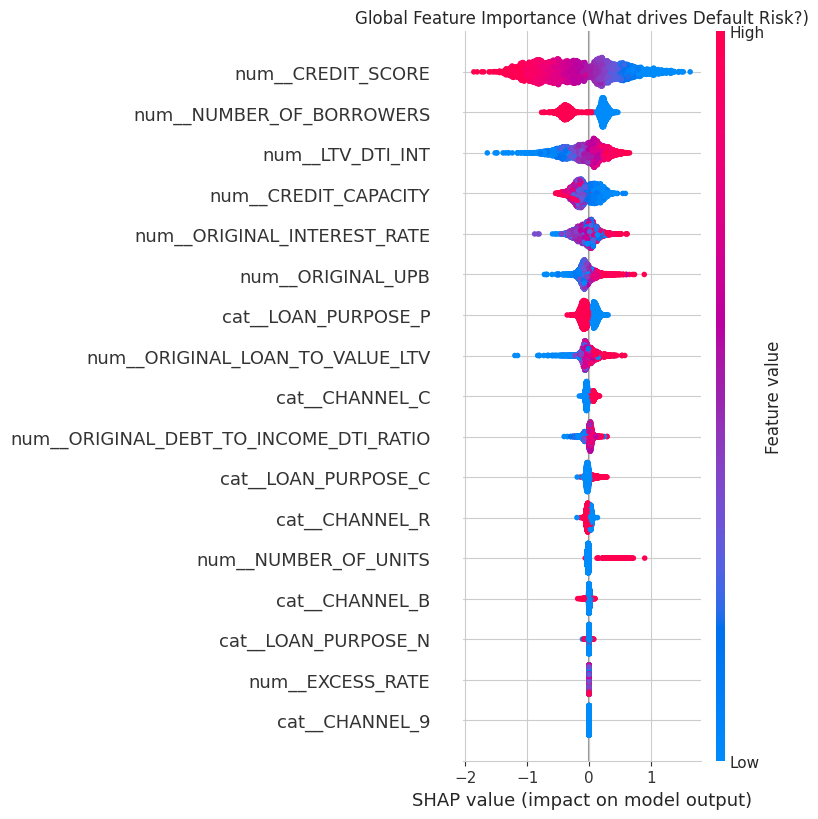


--> Analyzing Riskiest Applicant (Index 784)
    Predicted Default Probability: 82.63%
    Top Reasons for Rejection:


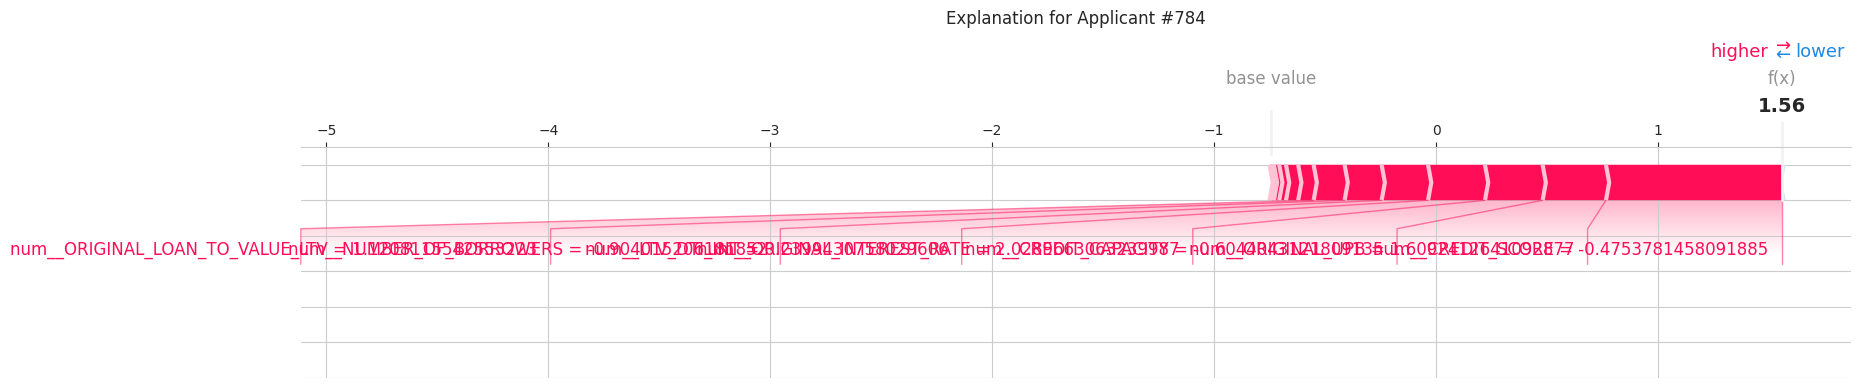

In [10]:
import shap
import matplotlib.pyplot as plt

def generate_regulatory_explanation(model, X_test):
    print("\n--> Generating SHAP Explainability Report...")
    print("    (Meeting 'Right to Explanation' Regulatory Requirement)")
    
    # 1. Initialize GPU-Accelerated Explainer
    # We pass the underlying XGBoost booster object for speed
    explainer = shap.TreeExplainer(model.named_steps['classifier'])
    
    # 2. Subsample for Visualization
    # Calculating SHAP for 600k rows is unnecessary for the chart. 
    # We take a random sample of 5,000 to represent the population.
    X_sample = X_test.sample(n=5000, random_state=42)
    
    # 3. Preprocess the sample
    # We must apply the same scaling/encoding as the training phase
    preprocessor = model.named_steps['preprocessor']
    X_sample_transformed = preprocessor.transform(X_sample)
    
    # Get feature names back from the preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # 4. Calculate SHAP Values
    shap_values = explainer.shap_values(X_sample_transformed)
    
    # --- VISUALIZATION A: The Global Risk Drivers ---
    plt.figure(figsize=(10, 6))
    plt.title("Global Feature Importance (What drives Default Risk?)")
    shap.summary_plot(shap_values, X_sample_transformed, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.show()
    
    # --- VISUALIZATION B: The "Reason Code" Generator ---
    # Shows why a SPECIFIC high-risk person was rejected
    # We find the person with the highest predicted probability in our sample
    
    # Predict probabilities for sample
    probs = model.predict_proba(X_sample)[:, 1]
    riskiest_idx = np.argmax(probs)
    
    print(f"\n--> Analyzing Riskiest Applicant (Index {riskiest_idx})")
    print(f"    Predicted Default Probability: {probs[riskiest_idx]:.2%}")
    print("    Top Reasons for Rejection:")
    
    # Force plot for single observation
    shap.force_plot(
        explainer.expected_value, 
        shap_values[riskiest_idx], 
        X_sample_transformed[riskiest_idx], 
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"Explanation for Applicant #{riskiest_idx}", y=1.5)
    plt.show()

# --- EXECUTE ---
generate_regulatory_explanation(model, X_test)

ctd..